**Install and Import Dependencies**

In [ ]:
!pip install tensorflow==2.5.1 tensorflow-gpu==2.5.1 opencv-python matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Import standard dependencies

import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
#Import tensorflow dependencies - function API (instead of sequential)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

**Set GPU Growth**


In [ ]:
#Avoid OUT OF MEMORY errors by setting GPU Memory Consumption Growth

gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Get dataset from drive, already in the correct folders (negatives, positives and anchors

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

# Setup paths and directories

POS_PATH = "/" + os.path.join("content", "drive", "MyDrive", "facial_recognition", 'positive')
NEG_PATH = "/" + os.path.join("content", "drive", "MyDrive", "facial_recognition", 'negative')
ANC_PATH = "/" + os.path.join("content", "drive", "MyDrive", "facial_recognition", 'anchor')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Move LFW Images to NEG_PATH

#done in external .py script ('cause google colab doesn't save status of data)

**Collect positives and anchors**

In [ ]:
#in phototaker.py (cause the cv2.VideoCapture doesn't work well with google colabs)

# Get Image Directories

In [ ]:
anchor = tf.data.Dataset.list_files(ANC_PATH + "/*.jpg").take(300)
positive = tf.data.Dataset.list_files(POS_PATH + "/*.jpg").take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + "/*.jpg").take(300)

# Preprocessing

In [ ]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img,(100,100))
    img = img / 255.0
    return img

# Create labelled dataset

In [ ]:
# (anchor, positive) => [1,1,1,1,...]
# (anchor, negative) => [0,0,0,0,...]

In [ ]:
positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

data = positives.concatenate(negatives)

In [ ]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [ ]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [ ]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)


# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Building the SIamese Neural Network

In [ ]:
def make_embedding():
    inp = Input(shape=(100,100,3), name = "input_image")

    #1st block
    c1 = Conv2D(64,(10,10), activation = "relu")(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    #2nd block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    #3rd block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    #4th block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [ ]:
embedding = make_embedding()

In [ ]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

In [ ]:
# create new class for custom neural network layer

class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [ ]:
def make_siamese_model():

    #Inputs for the model (input_image is the anchor)
    input_image = Input(name="input_img", shape=(100,100,3))
    validation_image = Input(name="validation_img", shape=(100,100,3))

    # Combine simaese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = "distance"
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    #Classification Layer
    classifier = Dense(1, activation="sigmoid")(distances)

    return Model(inputs=[input_image, validation_image], outputs = classifier, name = "SiameseNetwork")


In [ ]:
#test stuff

siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]     

#Training the model

In [ ]:
# create training_checkpoints folder if not created already

CHECKPOINTS = "training_checkpoints"

if not os.path.exists(CHECKPOINTS):
    os.makedirs(CHECKPOINTS)

In [ ]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [ ]:
opt = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [ ]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

### Training loop

In [ ]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            progbar.update(idx+1)
        print(loss.numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
EPOCHS = 50

train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 122s 315ms/step
0.23237577

 Epoch 2/50
27/27 [==============================] - 8s 285ms/step
0.3969223

 Epoch 3/50
27/27 [==============================] - 8s 280ms/step
0.36758745

 Epoch 4/50
27/27 [==============================] - 8s 280ms/step
0.42628694

 Epoch 5/50
27/27 [==============================] - 8s 298ms/step
0.14044434

 Epoch 6/50
27/27 [==============================] - 8s 290ms/step
0.049039252

 Epoch 7/50
27/27 [==============================] - 8s 286ms/step
0.0001365879

 Epoch 8/50
27/27 [==============================] - 8s 289ms/step
0.11782381

 Epoch 9/50
27/27 [==============================] - 8s 297ms/step
0.06553704

 Epoch 10/50
27/27 [==============================] - 8s 292ms/step
0.10629046

 Epoch 11/50
27/27 [==============================

# Evaluating the model, and saving it

In [ ]:
# metrics
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
# Get a batch of test data

test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])

# Post-processing the results (create threshold to convert prediction's floats into either 0 or 1)

predictions = [1 if prediction > 0.5 else 0 for prediction in y_hat]

In [ ]:
# Calculate Recall
m = Recall()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

In [ ]:
# Calculate Precision
p = Precision()
p.update_state(y_true, y_hat)
p.result().numpy()

1.0

# Visualize Results

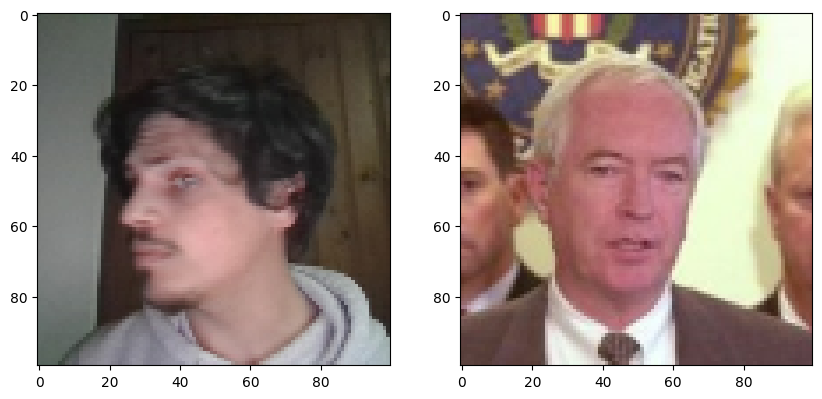

In [ ]:
NEGATIVE_SAMPLE = 0

plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[NEGATIVE_SAMPLE])
plt.subplot(1,2,2)
plt.imshow(test_val[NEGATIVE_SAMPLE])
plt.show()

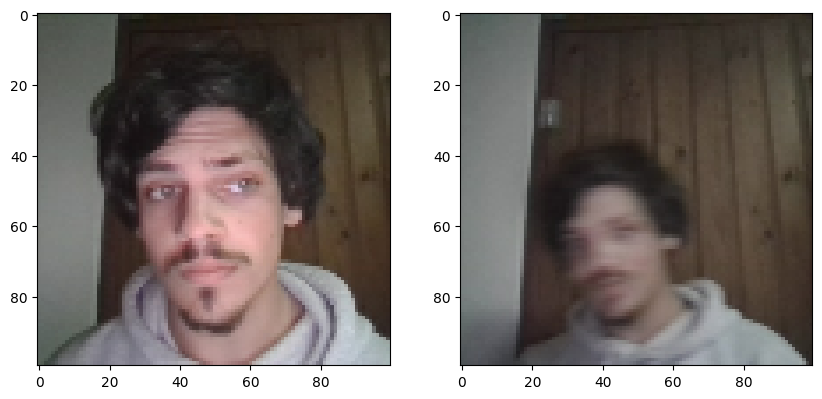

1.0


In [ ]:
POSITIVE_SAMPLE = 15

plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[POSITIVE_SAMPLE])
plt.subplot(1,2,2)
plt.imshow(test_val[POSITIVE_SAMPLE])
plt.show()
print(y_true[POSITIVE_SAMPLE])

In [ ]:
# Save weights
siamese_model.save("siamesemodel.h5")

In [ ]:
# reload model
model = tf.keras.models.load_model("siamesemodel.h5", \
                                   custom_objects={"L1Dist":L1Dist, "BinaryCrossentropy":tf.losses.BinaryCrossentropy})

In [ ]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_1 (L1Dist)              (None, 4096)         0           embedding[0][0]     

# *(Camera capture patch for google colab)*

<IPython.core.display.Javascript object>

Saved to input_image.jpg


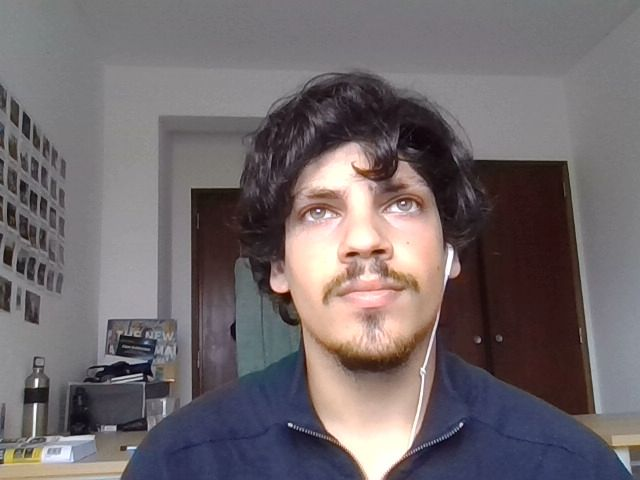

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='input_image.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

Saved to input_image.jpg


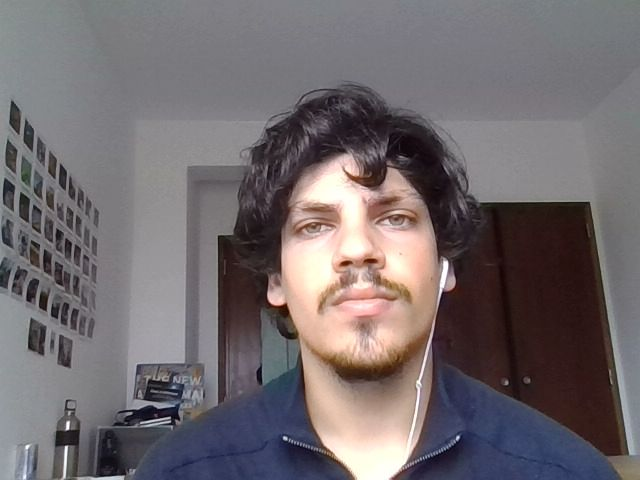

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

# Real time prediction

In [ ]:
import shutil

# setup folders and copy 300 files to 

VERIFICATION_PATH = os.path.join("application_data", "verification_images")

paths = [VERIFICATION_PATH,\
         os.path.join("application_data", "input_image")]
for path in paths:
    if not os.path.exists(path):
        os.makedirs(path)

        # this is just to be done once, so it is done at the time of creation of the folders
        for i, file in enumerate(os.listdir(POS_PATH)):
            if i == 300:
                break
            shutil.copy(os.path.join(POS_PATH, file), VERIFICATION_PATH)

        for i, file in enumerate(os.listdir(ANC_PATH)):
            if i == 300:
                break
            shutil.copy(os.path.join(ANC_PATH, file), VERIFICATION_PATH)

[[0.9990854]]
[[0.99971765]]
[[1.]]
[[0.9999653]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999958]]
[[0.5121936]]
[[0.9999945]]
[[0.9999999]]
[[0.9999975]]
[[0.9998318]]
[[0.9999932]]
[[0.9987465]]
[[0.99988794]]
[[0.9999999]]
[[0.99999976]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999974]]
[[0.4952919]]
[[1.]]
[[0.9997656]]
[[1.]]
[[0.39130402]]
[[0.9999981]]
[[1.]]
[[1.]]
[[0.9932121]]
[[1.]]
[[1.]]
[[1.]]
[[0.99998975]]
[[0.9999999]]
[[0.9999943]]
[[0.99988484]]
[[0.9999664]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999956]]
[[1.]]
[[1.]]
[[1.]]
[[0.9898747]]
[[0.9854483]]
[[0.9999944]]
[[1.]]
[[0.9999924]]
[[0.99988604]]
[[0.99999976]]
[[1.]]
[[0.9999993]]
[[0.99999344]]
[[0.85890305]]
[[0.9995427]]
[[0.9979634]]
[[1.]]
[[0.9999987]]
[[0.9683302]]
[[0.9371004]]
[[1.]]
[[0.9977977]]
[[0.9999999]]
[[0.8938709]]
[[0.99997306]]
[[0.9999976]]
[[0.99818593]]
[[0.99825794]]
[[0.99999964]]
[[1.]]
[[1.]]
[[1.]]
[[0.9958467]]
[[0.99998426]]
[[0.9999931]]
[[0.82071793]]
[[0.8995224]]
[[0.99907047]]
[[0.999990

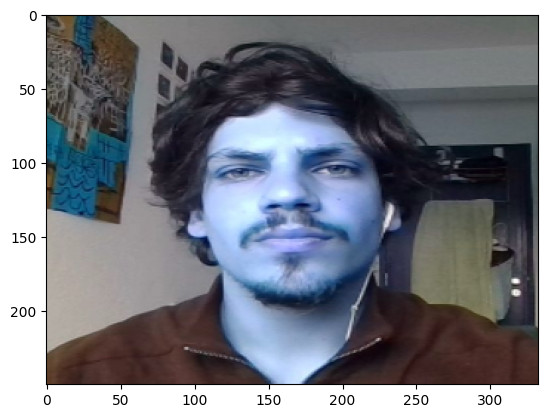

In [ ]:
# Detection Threshold = metric above which prediction is considered postive
# Verification Threshold = number of detections needed to consider input verified
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess('input_image.jpg')
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
        print(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    print("DETECTION:", detection)
    print("VERIFICATION:",verification)
    
    return results, verified
    
take_photo()

# resize input_image
img = cv2.imread("input_image.jpg")
# Get the height and width of the frame
height, width, _ = img.shape
size = (250, 250)

if width > height:
    size = (int(width * 250 / height), 250)
else:
    size = (250, int(height * 250 / width))

# Resize the frame to the new dimensions
img = cv2.resize(img, size)

# Crop the resized frame to be a square with dimensions of 250x250 pixels
h, w = img.shape[:2]
left = (w - 250) // 2
top = (h - 250) // 2
right = left + 250
bottom = top + 250
img = img[top:bottom, left:right]
cv2.imwrite("input_image.jpg", img)


results, verified = verify(model, 0.5, 0.5)

print(results)

print(verified)
plt.imshow(img)
plt.show()
